In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import cv2
import shutil

import numpy as np
import pandas as pd
import pydicom as dicom
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [5]:
train_dir = Path('E:\data\RSNA2024')

class CFG:
    random_seed = 42

    size = 256
    
    ROOT_FOLDER = train_dir
    DEST_FOLDER = train_dir / 'original'
    IMAGES_DIR = ROOT_FOLDER / 'train_images'
    OUTPUT_DIR = ROOT_FOLDER / f'pngs_{size}'
    FILES_CSV = DEST_FOLDER / 'train_files.csv'
    TRAIN_CSV = ROOT_FOLDER / 'train.csv'
    TRAIN_DESC_CSV = ROOT_FOLDER / 'train_series_descriptions.csv'
    COORDS_CSV = ROOT_FOLDER / 'train_label_coordinates.csv'

In [6]:
CFG.OUTPUT_DIR

WindowsPath('E:/data/RSNA2024/pngs_256')

In [165]:
files = [str(item) for item in CFG.IMAGES_DIR.rglob('*.dcm') ]
len(files)

147218

In [8]:
files[1000]

'E:\\data\\RSNA2024\\train_images\\1028684462\\1958018915\\26.dcm'

### Get metadata

In [9]:
ds = dicom.dcmread(files[63])

In [10]:
ds.pixel_array.shape

(462, 448)

In [46]:
print(ds)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 100206310.1.12
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 100206310.1.12
(0008, 0023) Content Date                        DA: '20240503'
(0008, 0033) Content Time                        TM: '223744.084561'
(0008, 103e) Series Description                  LO: 'T2'
(0010, 0020) Patient ID                          LO: '100206310'
(0018, 0050) Slice Thickness                     DS: '4.0'
(0018, 0088) Spacing Between Slices              DS: '4.48'
(0018, 5100) Patient Position          

In [108]:
ds.get_item('PhotometricInterpretation').keyword, ds.get_item('PhotometricInterpretation').tag

('PhotometricInterpretation', (0028, 0004))

In [114]:
for i in ds.items():
    # print(i[1])
    if i[1].keyword == 'PixelData':
        continue
    print(i[1].name, i[1].keyword, i[1].value)

SOP Instance UID SOPInstanceUID 100206310.1.12
Content Date ContentDate 20240503
Content Time ContentTime 223744.084561
Series Description SeriesDescription T2
Patient ID PatientID 100206310
Slice Thickness SliceThickness 4
Spacing Between Slices SpacingBetweenSlices 4.48
Patient Position PatientPosition HFS
Study Instance UID StudyInstanceUID 100206310
Series Instance UID SeriesInstanceUID 100206310.1792451510
Instance Number InstanceNumber 12
Image Position (Patient) ImagePositionPatient [17.410165861037, -58.370088036308, -397.07162417514]
Image Orientation (Patient) ImageOrientationPatient [0.03407286005191, 0.9994056428998, 0.00523461057921, -0.0225372470955, 0.00600466399557, -0.999727971252]
Frame of Reference UID FrameOfReferenceUID 1.2.826.0.1.3680043.8.498.81276267968322114091467077873577301238
Slice Location SliceLocation 28.401862438532
Samples per Pixel SamplesPerPixel 1
Photometric Interpretation PhotometricInterpretation MONOCHROME2
Rows Rows 462
Columns Columns 448
Pixe

In [146]:
ds.get('SeriesDescription')

'T2'

In [13]:
type(ds)

pydicom.dataset.FileDataset

In [83]:
ds.pixel_array.shape, ds.Rows, ds.PhotometricInterpretation, ds.SeriesDescription

((462, 448), 462, 'MONOCHROME2', 'T2')

In [116]:
len(files)

147218

In [126]:
# train_desc_df = pd.read_csv(CFG.TRAIN_DESC_CSV)
# # train_desc_df['folders'] = train_desc_df['study_id'] + train_desc_df['series_id']
# train_desc_df['filename'] = train_desc_df.apply(lambda row: f'{CFG.IMAGES_DIR}\\{row.study_id}\\{row.series_id}', axis=1)

# train_desc_df.shape

(6294, 4)

In [127]:
# train_desc_df.iloc[0]

study_id                                                      4003253
series_id                                                   702807833
series_description                                   Sagittal T2/STIR
filename              E:\data\RSNA2024\train_images\4003253\702807833
Name: 0, dtype: object

In [129]:
# folders = train_desc_df.filename.to_list()

# len(folders)

6294

In [134]:
# folder = Path(folders[0])
# files = [str(item) for item in folder.rglob('*.dcm') ]
# len(files)

15

In [138]:
# [f.split('\\')[-1][:-4] for f in files]

In [166]:
keys = ['InstanceNumber', 'Rows', 'Columns', 'SliceThickness', 'SpacingBetweenSlices', 'PatientPosition', 'SeriesDescription']

def process(f, size=CFG.size, keys=keys):
    series = f.split('\\')[-2]
    study = f.split('\\')[-3]
    image = f.split('\\')[-1][:-4]
    
    ds = dicom.dcmread(f)
    
    values = []

    for k in keys:
        values.append(ds.get(k))

    values = [study, series, image] + values
    
    return tuple(values)

In [167]:
data = Parallel(n_jobs=16)(
    delayed(process)(f)
    # for f in tqdm(files[:24])
    for f in tqdm(files)
)

  0%|          | 0/147218 [00:00<?, ?it/s]

In [168]:
len(files)

147218

In [169]:
data[:2]

[('100206310', '1012284084', '1', '1', 320, 320, '3.5', '3.5', 'HFS', 'T2'),
 ('100206310', '1012284084', '10', '10', 320, 320, '3.5', '3.5', 'HFS', 'T2')]

In [170]:
columns = [k.lower() for k in keys]
columns = ['study_id', 'series_id', 'image'] + columns

columns

['study_id',
 'series_id',
 'image',
 'instancenumber',
 'rows',
 'columns',
 'slicethickness',
 'spacingbetweenslices',
 'patientposition',
 'seriesdescription']

In [171]:
files_df = pd.DataFrame(data, columns=columns)
files_df.shape

(147218, 10)

In [172]:
files_df.sample(5)

,study_id,series_id,image,instancenumber,rows,columns,slicethickness,spacingbetweenslices,patientposition,seriesdescription
53275,2421664513,2670719714,13,13,544,512,4.0,4.48,HFS,T1
36258,1972541574,2167800642,15,15,512,512,4.0,4.00,HFS,T1
112020,3919334786,59089913,169,169,512,512,2.8,1.40,FFS,T2
132203,624497208,2606365715,4,4,384,384,4.0,4.40,HFS,T2
122462,4200324709,1843843230,20,20,324,384,4.0,5.20,HFS,T2


In [173]:
files_df.to_csv(CFG.FILES_CSV, index=False)

### Convert files to png

In [14]:
f = files[0]
f.split('\\')

['E:', 'data', 'RSNA2024', 'train_images', '100206310', '1012284084', '1.dcm']

  0%|          | 0/3 [00:00<?, ?it/s]

100206310 14


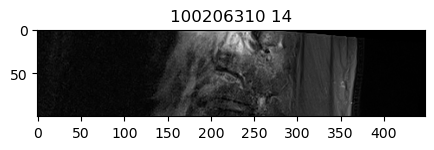

100206310 15


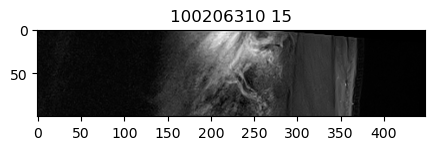

100206310 16


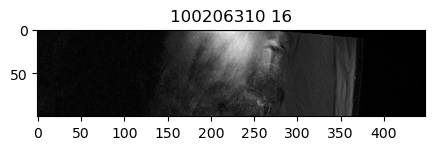

In [78]:
for f in tqdm(files[65:68]):
    series = f.split('\\')[-2]
    patient = f.split('\\')[-3]
    image = f.split('\\')[-1][:-4]
    print(patient, image)

    ds = dicom.dcmread(f)
    img = ds.pixel_array

    img = (img - img.min()) / (img.max() - img.min())

    if ds.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img
        
    plt.figure(figsize=(5, 5))
    plt.imshow(img[:100], cmap="gray")
    plt.title(f"{patient} {image}")
    plt.show()

In [54]:
shutil.rmtree(str(CFG.OUTPUT_DIR))
os.makedirs(str(CFG.OUTPUT_DIR), exist_ok=True)

In [84]:
def process(f, size=CFG.size, save_folder=str(CFG.OUTPUT_DIR), extension="png"):
    series = f.split('\\')[-2]
    study = f.split('\\')[-3]
    image = f.split('\\')[-1][:-4]

    ds = dicom.dcmread(f)
    img = ds.pixel_array

    img = (img - img.min()) / (img.max() - img.min())

    if ds.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img

    img = cv2.resize(img, (size, size))

    file_name =  f"{save_folder}\\{study}_{series}_{image}.{extension}"

    cv2.imwrite(file_name, (img * 255).astype(np.uint8))

    return study, series, image, ds.Rows, ds.Columns

In [85]:
# process(files[0])

In [89]:
data = Parallel(n_jobs=16)(
    delayed(process)(f)
    # for f in tqdm(files[:24])
    for f in tqdm(files)
)

  0%|          | 0/147218 [00:00<?, ?it/s]

In [115]:
data[:10]

NameError: name 'data' is not defined

In [67]:
# list(zip(*foo))

In [90]:
files_df = pd.DataFrame(data, columns=['study_id', 'series_id', 'instance', 'rows', 'columns'])
files_df.shape

(147218, 5)

In [95]:
# files_df.to_csv(CFG.FILES_CSV, index=False)